In [1]:
from nos.client import InferenceClient, TaskType

# Create a client that connects to the inference server via gRPC (50051)
client = InferenceClient()

2023-07-05 16:03:58.598 | DEBUG    | nos.protoc:__init__:32 - Compiling protos from: [PosixPath('/home/scott/dev/nos/nos/proto')]
2023-07-05 16:03:58.599 | DEBUG    | nos.protoc:__init__:34 - Compiling /home/scott/dev/nos/nos/proto/nos_service.proto
2023-07-05 16:03:58.600 | DEBUG    | nos.protoc:compile:55 - Compiling protos:  -I/home/scott/anaconda3/envs/base-gpu-new/lib/python3.9/site-packages/grpc_tools/_proto --python_out=/home/scott/.nos/cache/protobuf --grpc_python_out=/home/scott/.nos/cache/protobuf --proto_path=/home/scott/dev/nos/nos/proto nos_service.proto
2023-07-05 16:03:58.602 | DEBUG    | nos.protoc:compile:59 - Compilation took: 0.00 seconds
2023-07-05 16:03:58.603 | DEBUG    | nos.protoc:__init__:36 - Compiled modules: ['nos_service_pb2', 'nos_service_pb2_grpc']
2023-07-05 16:03:58.604 | DEBUG    | nos.protoc:import_module:71 - Loading module: /home/scott/.nos/cache/protobuf/nos_service_pb2.py
2023-07-05 16:03:58.608 | DEBUG    | nos.protoc:import_module:71 - Loading m

In [2]:
client.WaitForServer()

True

In [3]:
client.IsHealthy()

True

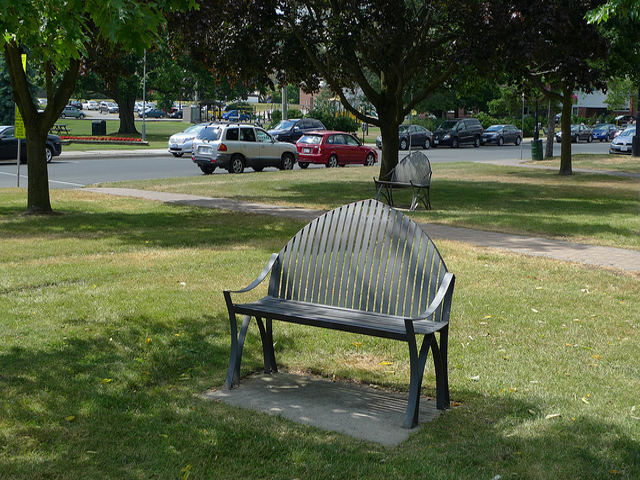

In [4]:
import requests
from PIL import Image


url = "https://raw.githubusercontent.com/open-mmlab/mmdetection/main/demo/demo.jpg"
img = Image.open(requests.get(url, stream=True).raw).resize((640, 480))
img

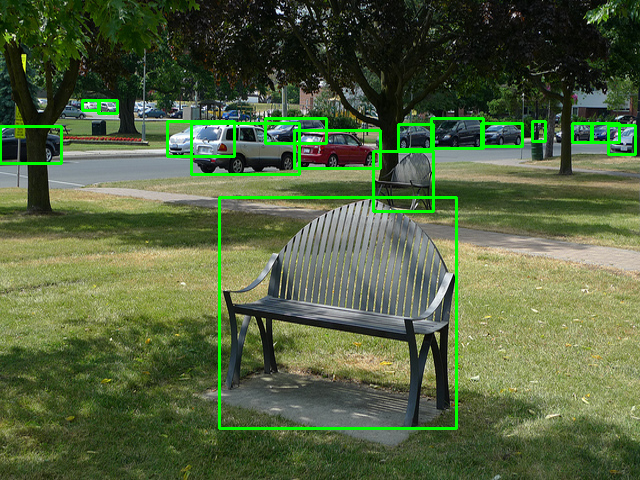

In [6]:
import cv2
import numpy as np

def visualize_det2d(img: np.ndarray, bboxes: np.ndarray, labels: np.ndarray) -> np.ndarray:
    """Visualize 2D detection results on an image."""
    vis = np.asarray(img).copy()
    for bbox, label in zip(bboxes.astype(np.int32), labels):
        cv2.rectangle(vis, (bbox[0], bbox[1]), (bbox[2], bbox[3]), (0, 255, 0), 2)
    return vis

# Run YOLOX prediction on the image and get the prediction results as a dictionary.
# predictions = {"bboxes", "scores", "labels"}.
predictions = client.Run(TaskType.OBJECT_DETECTION_2D, "yolox/medium", images=[img])
for idx, (img, bboxes, scores, labels) in enumerate(zip([img], predictions["bboxes"], predictions["scores"], predictions["scores"])):
    display(Image.fromarray(visualize_det2d(img, bboxes, labels)))

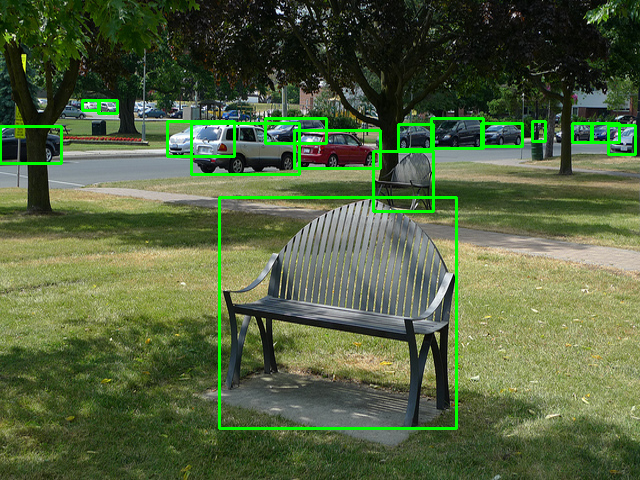

In [7]:
# Let's do the same for yolox/nano-trt (The TensorRT version of the above model). Note that this one will take a bit longer on the first pass since we need to compile it first.
predictions = client.Run(TaskType.OBJECT_DETECTION_2D, "yolox/medium-trt", images=[img])
for idx, (img, bboxes, scores, labels) in enumerate(zip([img], predictions["bboxes"], predictions["scores"], predictions["scores"])):
    display(Image.fromarray(visualize_det2d(img, bboxes, labels)))

In [8]:
%%timeit -n 100
predictions = client.Run(TaskType.OBJECT_DETECTION_2D, "yolox/medium", images=[img])

28.8 ms ± 12.9 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [ ]:
# Run a single prediction with TRT to trigger compilation so we don't skew timing results
predictions = client.Run(TaskType.OBJECT_DETECTION_2D, "yolox/medium-trt", images=[img]) 

In [10]:
%%timeit -n 100
predictions = client.Run(TaskType.OBJECT_DETECTION_2D, "yolox/medium-trt", images=[img])

22.1 ms ± 553 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
